In [1]:
import toml
import sys
sys.path = ["/scratch/x77/ahg157/software/python-ale/build/lib.linux-x86_64-3.9"] + sys.path
import pyale
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm


## Load grid information into dataset

In [2]:
ds = xr.open_dataset('/scratch/x77/amh157/mom6/archive/zstar/output300/ocean_static.nc')
ds

<xarray.Dataset>
Dimensions:       (xh: 160, yh: 800, time: 1, xq: 161, yq: 801)
Coordinates:
  * xh            (xh) float64 0.125 0.375 0.625 0.875 ... 39.38 39.63 39.88
  * yh            (yh) float64 -70.15 -70.07 -69.98 -69.89 ... 69.98 70.07 70.15
  * time          (time) object 0001-01-01 00:00:00
  * xq            (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * yq            (yq) float64 -70.19 -70.11 -70.02 -69.94 ... 70.02 70.11 70.19
Data variables: (12/25)
    areacello     (yh, xh) float32 ...
    deptho        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    ...            ...
    dyCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dyCv          (yq, xh) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
Attributes:
    NumFilesInSet:  1
    title:          ANU_tub Sector
    grid_type:      regular
    grid_tile:      N/A

In [3]:
restart_filename = '/scratch/x77/amh157/mom6/archive/zstar/restart300/MOM.res.nc'
ds2 = xr.open_dataset(restart_filename)

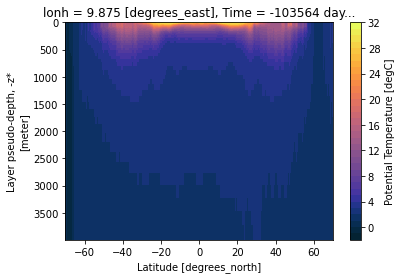

In [4]:
vlev = np.linspace(-2,32,35)
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()

## Testing the HYCOM1 case

Firstly, let's load the original configuration out the model to confirm that we get the correct layer structure.

In [9]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_hycom1.toml")
cs = pyale.mom_init_cs(params);

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [6]:
pyale.load_mom_restart(cs, restart_filename)
hycom1_cs = pyale.mom_init_regrid(cs, params, "HYCOM1")
(h, temp, salt) = pyale.accelerate_ale(cs, hycom1_cs, iter=1)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  T
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'HYBRID:hycom1_75_800m.nc,sigma2,FNC1:1.08,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0900000000000001        1.0900000000000001        1.1000000000000001        1.1100000000000001        1.1300000000000001        1.1600000000000001        1.1900000000000002        1.2400000000000000        1.2900000000000000        1.3700000000000001        1.4500000000000002        1.5600000000000001        1.7000000000000002        1.860000000000

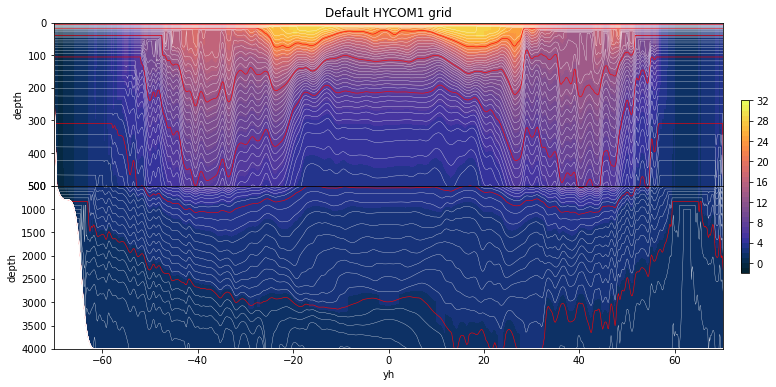

In [10]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'r',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
plt.title('Default HYCOM1 grid')
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'r',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)


ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c);

## Summary

The above plot is consistent with the model grid. Layers do a good job of following isopycnals throughout much of the interior. 

The shortcomings here are in the higher latitudes, where deepening mixed layers result in very steeply sloping isopycnals, and the HYCOM1 algorithm converts to geopotential layers. In addition, there are some relatively deep isopycnal layers at about 30° latitude in both hemispheres which are less than ideal.

We attempt to address these shortcomings by changing the vertical spacing of the z grid...

In [19]:
#params["ALE_COORDINATE_CONFIG"] = "HYBRID:hycom1_75_800m.nc,sigma2,FNC1:1.08,1000,4.5,.01"
params["MAX_LAYER_THICKNESS_CONFIG"] = "FNC1:1.08,8000.0,4.5,.01"

cs = pyale.mom_init_cs(params);

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [20]:
pyale.load_mom_restart(cs, restart_filename)
hycom1_cs = pyale.mom_init_regrid(cs, params, "HYCOM1")
(h, temp, salt) = pyale.accelerate_ale(cs, hycom1_cs, iter=1)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  T
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'HYBRID:hycom1_75_800m.nc,sigma2,FNC1:1.08,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0900000000000001        1.0900000000000001        1.1000000000000001        1.1100000000000001        1.1300000000000001        1.1600000000000001        1.1900000000000002        1.2400000000000000        1.2900000000000000        1.3700000000000001        1.4500000000000002        1.5600000000000001        1.7000000000000002        1.860000000000

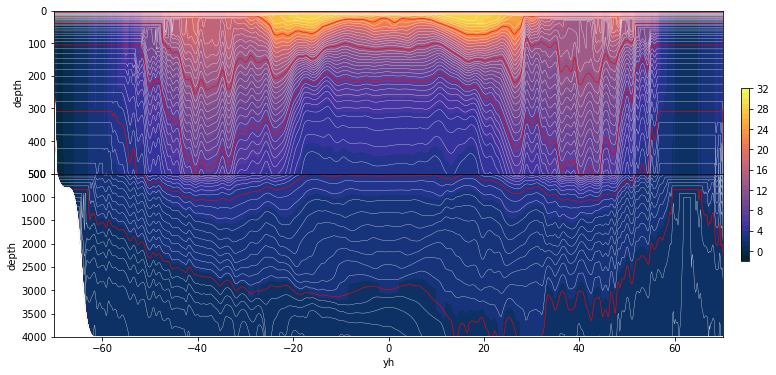

In [21]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'r',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'r',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

## Summary

This is an extreme case which demonstrates the difficulty in forcing HYCOM1 to try to convert to the isopycnal coordinates in convecting regions. Here we have shoaled the z* maximum depth to just 1000m, meaning more of the ocean at those depths are isopcynal. But the isopycnals slope so steeply as to give a noisy coordinate which is almost certain to perform poorly. 

**In conclusion, it is hard to see how we can force HYCOM1 to do a better job than the orignal parameters.**